In [2]:
"""
# Tumor(Breast) Image Classification Using CNN
"""
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
"""
# Download image set from kaggle.
"""
! kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

 94% 184M/195M [00:02<00:00, 143MB/s]
100% 195M/195M [00:02<00:00, 75.8MB/s]


In [4]:
"""
# unzip data
"""
import zipfile
zf = "/content/breast-ultrasound-images-dataset.zip"
target_dir = "/content/dataset/cnn/tumor_breast"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [5]:
"""
# Data Import
# Import basic libraries
"""

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os 
import pathlib 
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers 

Mounted at /content/drive


In [7]:
"""
# Path and class names
"""

path = '/content/dataset/cnn/tumor_breast/Dataset_BUSI_with_GT'
data_dir = pathlib.Path(path)

class_names = np.array([item.name for item in data_dir.glob("*")])
class_names

"""
# Image count
"""

benignPath = pathlib.Path(os.path.join(data_dir,'benign'))
normalPath = pathlib.Path(os.path.join(data_dir,'normal'))
malignantPath = pathlib.Path(os.path.join(data_dir,'malignant'))

benignImageCount = len(list(benignPath.glob('*.png')))
malignantImageCount = len(list(malignantPath.glob('*.png')))
normalImageCount = len(list(normalPath.glob('*.png')))
totalImageCount = benignImageCount + malignantImageCount + normalImageCount

print("Total Images: ", totalImageCount)
print("Benign (non-dangerous) Images: {}({})".format(benignImageCount, round(benignImageCount*100/totalImageCount, 2)))
print("Malignant (dangerous) Images: {}({})".format(malignantImageCount, round(malignantImageCount*100/totalImageCount, 2)))
print("Normal (No Traces) Images: {}({})".format(normalImageCount, round(normalImageCount*100/totalImageCount, 2)))

Total Images:  1578
Benign (non-dangerous) Images: 891(56.46)
Malignant (dangerous) Images: 421(26.68)
Normal (No Traces) Images: 266(16.86)


In [13]:
"""
# CNN
"""

batch_size = 32
img_height = 224
img_width = 224

"""
# Separating data sets
"""


train_data = image_dataset_from_directory(data_dir,validation_split=0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size)

val_data = image_dataset_from_directory(data_dir,validation_split=0.2,subset="validation",seed=123,image_size=(img_height,img_width),batch_size=batch_size)


Found 1578 files belonging to 3 classes.
Using 1263 files for training.
Found 1578 files belonging to 3 classes.
Using 315 files for validation.


In [14]:
"""
# Define Model
# Rescale images add a Dropout to avoid the overfitting
# Softmax as activation for dense layer, Relu for conv layers
# 7 layer CNN Model Architecture with 3 Convolution layer each followed by max pooling layer
# Filter size =3X3 and Activation function = Relu
"""

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3,activation="softmax")
])

In [15]:
"""
# Compile and fit the Model
"""

model.compile(optimizer="Adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])

epochs = 2
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data, 
                    batch_size=batch_size)


Epoch 1/2
40/40 [==============================] - 96s 2s/step - loss: 0.8895 - accuracy: 0.5748 - val_loss: 0.7488 - val_accuracy: 0.6952
Epoch 2/2
40/40 [==============================] - 92s 2s/step - loss: 0.6506 - accuracy: 0.7070 - val_loss: 0.7050 - val_accuracy: 0.7048


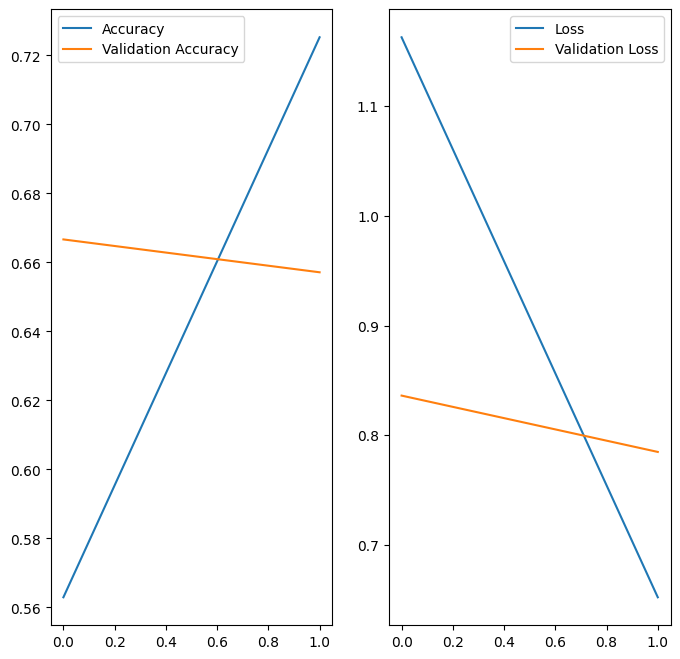

In [11]:
"""
# History Keys
"""

history.history.keys()

"""# Accuracy vs Lost"""

acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

10/10 [==============================] - 33s 3s/step - loss: 0.7847 - accuracy: 0.6571
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 250, 250, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                   

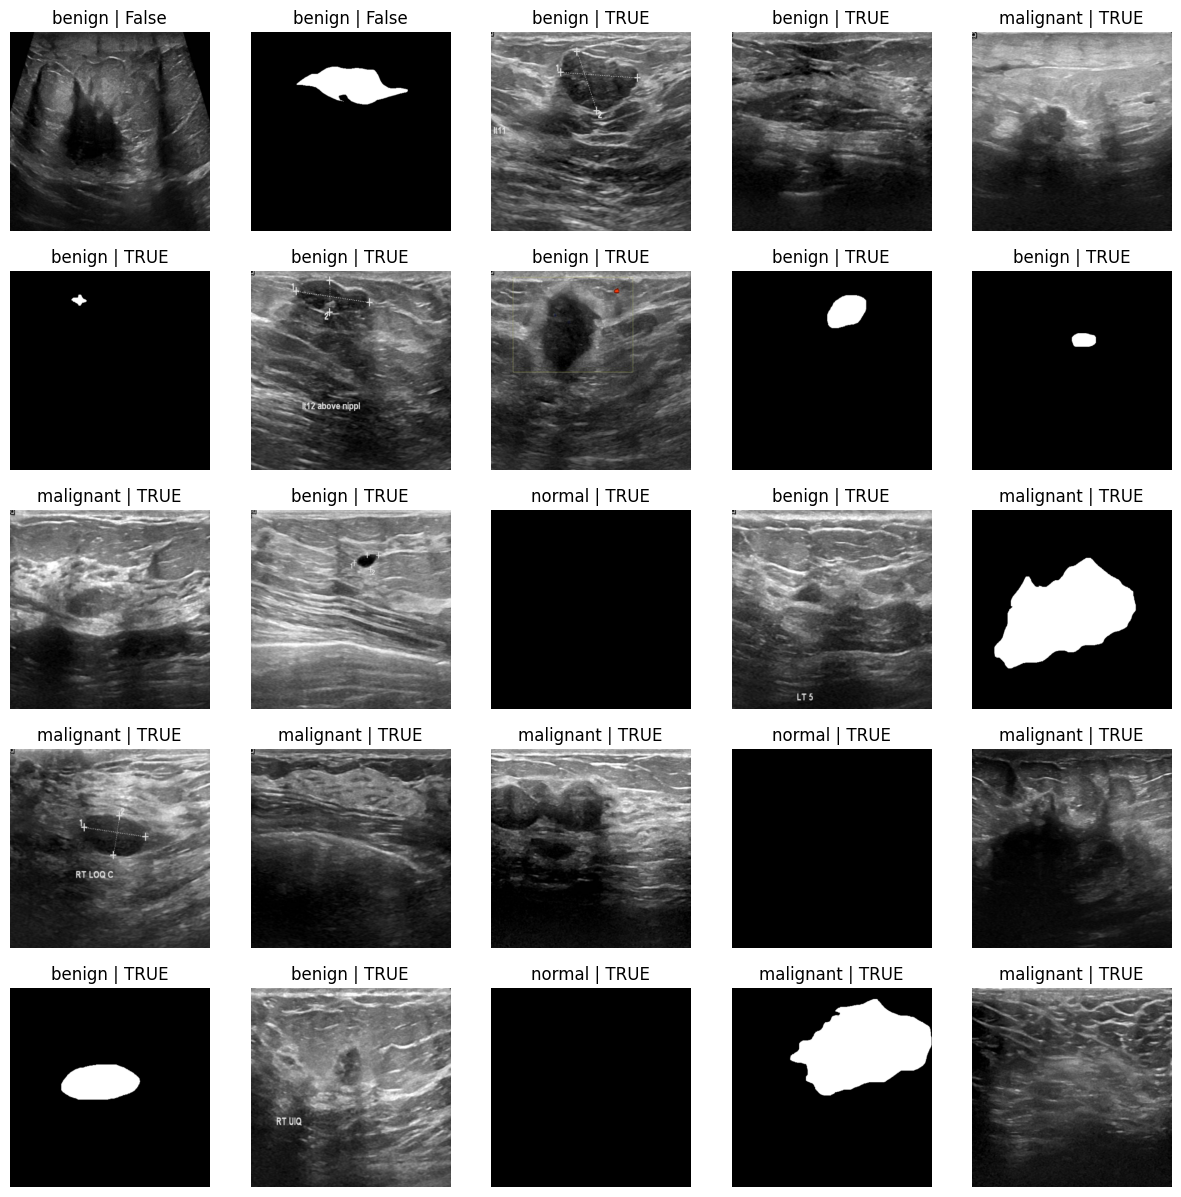

In [12]:
"""
# Model Evaluation returns loss and accuracy
"""

model.evaluate(val_data)

"""
# Model summary
"""

model.summary()

"""
# Test Model
"""

plt.figure(figsize=(15, 15))
class_names = val_data.class_names
result = ' | False'
for images, labels in val_data.take(1):
    for i in range(25):
        
        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        
        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'
            
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result)
        plt.axis("off")